# Redes domesticas

O detecção de anomalias em redes domesticas é um projeto de iniciação cientifica que visa a validação dos melhores algoritmos para criação de um modelo de detecção de anomalias em redes domesticas usando aprendizado supervisionado afim de adicionar uma camada a mais de segurança em trafego domestico.

Para essa solução usarei a metodologia CRISP-DM.
Por que essa metodologia?.
* Organização.
* Planeijamento.
* Independe do tipo de projeto.

**Etapas da metodologia**.

1. Etapa - **Entendimento do negócio**.
* Objetivos do projéto.
* Critérios de sucesso.
* Recursos e contingenciamentos.
* Objetivos do data mining.
* Planeijamento estrutural.
2. Etapa - **Entendimento dos dados**.
* Coleta.
* Descrição.
* Exploração.
* Verificação da qualidade dos dados.
3. Etapa - **Preparação dos dados**.
* Seleção.
* Limpeza.
* Construção.
* Integração.
* Formatação.
4. Etapa - **Modelagem**.
* Escolha a tecnica de modelagem.
* Design de teste.
* Construção do modelo.
* Avaliação.
5. Etapa - **Revisão dos resultados**.
* Revisão dos critérios de sucesso.
* Revião do processo completo.
* Determinação de proximos passos.

**Fonte dos dados**: [iotanalytics](https://iotanalytics.unsw.edu.au/) e [stratosphereips](https://www.stratosphereips.org/datasets-normal)

## 2- Entendimento

A coleta dos dados variam para cada tipo de trafego e as fontes para cada tipo foram:

*  IOT: Benigno-> [iotanalytics](https://iotanalytics.unsw.edu.au/) | Maligno-> [None]()
* Normal: Benigno-> [stratosphereips](https://www.stratosphereips.org/datasets-normal) | Maligno-> [None]()
* Movel: Benigno-> [None]() | Maligno-> [None]()

In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Index
import nfstream
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
pd.set_option("styler.format.thousands", ",")

In [3]:
# função que percorre uma determinada pasta e converte todos os pcaps dessa pasta para csv e adciona o label

def concat_csv_and_pcap(mypath: str, fileName:str, label:int) -> DataFrame:

    lista = []

    for arg in os.listdir(path=mypath):

        name = os.path.join(mypath, arg)

        if arg.endswith(".pcap"):
            
            try:
                df = nfstream.NFStreamer(source= os.path.join(mypath, arg),statistical_analysis=True).to_pandas()
                lista.append(df)

            except Exception as e:
                print(f"Error!, ao ler o arquivo {name}")
                exit()
    
    trafego = pd.concat(lista)
    trafego.reset_index(drop=True, inplace=True)
    trafego['label'] = label # rotulando o trafego
    trafego.to_csv('./csv/' + fileName) # salvando
    return trafego

In [4]:

if os.path.exists("./csv/trafego.csv"):

    dados = pd.read_csv("./csv/trafego.csv", index_col=0)

else:

    dados_fixo = concat_csv_and_pcap("./pcaps/Fixo/", "trafego_normal.csv", 0)
    dados_IOT = concat_csv_and_pcap("./pcaps/IOT/", "trafego_IOT.csv", 1)

    dados = pd.concat([dados_IOT, dados_fixo])
    dados.reset_index(drop=True, inplace=True)
    dados.to_csv("./csv/trafego.csv")



Gerando relatorio para uma analise dos dados.

In [5]:
from ydata_profiling import ProfileReport

# para evitar que toda ves que rodar a aplicação esse campo sej processado gastando recurso computacional
if not os.path.exists("relatorio.html"):

    relatorio = ProfileReport(dados, minimal=True)
    relatorio.to_file("relatorio.html")

/home/maycon/IC-RedesDomesticas/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# uma descrição de cada coluna será feita em um arquivo labesDrescription.pdf contido na raiz do projeto

dados.head()

,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,application_name,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,label
0,0,0,192.168.1.111,2c:6e:85:56:dd:b7,2c:6e:85,52754,239.255.255.250,01:00:5e:7f:ff:fa,01:00:5e,1900,...,SSDP,System,0,6,239.255.255.250:1900,NaN,NaN,NaN,NaN,1
1,1,0,192.168.1.111,2c:6e:85:56:dd:b7,2c:6e:85,5353,224.0.0.251,01:00:5e:00:00:fb,01:00:5e,5353,...,MDNS,Network,0,6,_googlecast._tcp.local,NaN,NaN,NaN,NaN,1
2,2,0,fe80::6529:a551:88b9:f0ca,2c:6e:85:56:dd:b7,2c:6e:85,5353,ff02::fb,33:33:00:00:00:fb,33:33:00,5353,...,MDNS,Network,0,6,_googlecast._tcp.local,NaN,NaN,NaN,NaN,1
3,3,0,192.168.1.191,60:6c:66:cb:78:61,60:6c:66,41081,192.168.33.254,00:13:33:b0:18:50,00:13:33,53,...,DNS,Network,0,6,mobile.slashdot.org,NaN,NaN,NaN,NaN,1
4,4,0,192.168.1.191,60:6c:66:cb:78:61,60:6c:66,49000,192.168.33.254,00:13:33:b0:18:50,00:13:33,53,...,DNS.Google,Network,0,6,accounts.google.com,NaN,NaN,NaN,NaN,1


Temos ao todo 87 colunas para analisar.

In [7]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 819592 entries, 0 to 819591
Data columns (total 87 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            819592 non-null  int64  
 1   expiration_id                 819592 non-null  int64  
 2   src_ip                        819592 non-null  object 
 3   src_mac                       819592 non-null  object 
 4   src_oui                       819592 non-null  object 
 5   src_port                      819592 non-null  int64  
 6   dst_ip                        819592 non-null  object 
 7   dst_mac                       819592 non-null  object 
 8   dst_oui                       819592 non-null  object 
 9   dst_port                      819592 non-null  int64  
 10  protocol                      819592 non-null  int64  
 11  ip_version                    819592 non-null  int64  
 12  vlan_id                       819592 non-nul

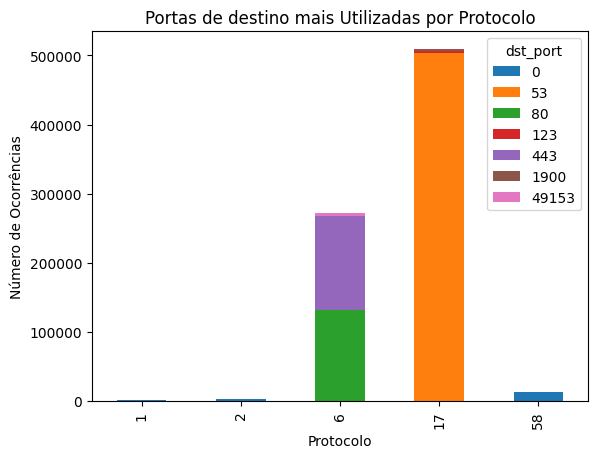

In [8]:
# Contar o número de vezes que cada porta foi usada para cada protocolo
counts1 = dados.groupby(['protocol', 'dst_port']).size().reset_index(name='count')

# Ordenar os dados pela contagem decrescente
counts1 = counts1.sort_values(['protocol', 'count'], ascending=[True, False])

# Selecionar as 3 portas mais utilizadas por cada protocolo
top_ports1 = counts1.groupby('protocol').head(3)

# Gerar o gráfico de barras empilhadas
fig, ax = plt.subplots()
top_ports1.pivot(index='protocol', columns='dst_port', values='count').plot(kind='bar', stacked=True, ax=ax)



# Personalizar o gráfico
ax.set_title('Portas de destino mais Utilizadas por Protocolo')
ax.set_xlabel('Protocolo')
ax.set_ylabel('Número de Ocorrências')

# Mostrar o gráfico
plt.show()

Vamos analisar melhor os dados faltantes

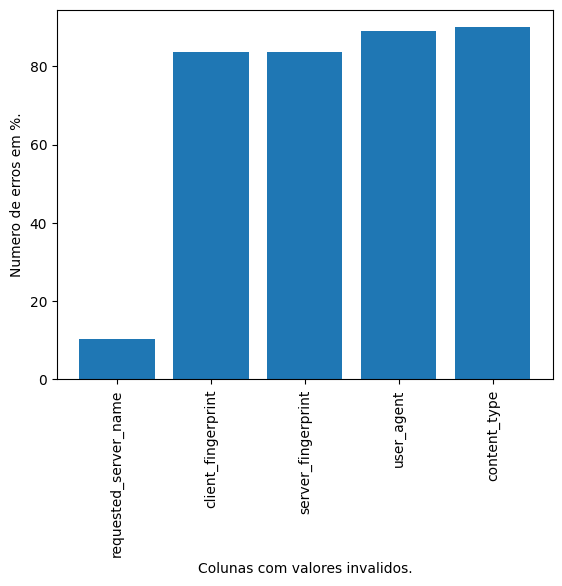

In [9]:
# obtém o número de pontos de dados ausentes por coluna
data_cols_erros = dados.isnull().sum()

# filtrando someste os que tem valores nulos > 0
data_cols_erros = data_cols_erros[data_cols_erros > 0]

size = len(dados.index)

# obtendo uma lista das colunas
cols_name = data_cols_erros.index.tolist()

# obtendo os uma lista com a porcentagem dos erros para cada coluna
erros = [float((item / size) * 100) for item in data_cols_erros.values.tolist()]

plt.bar(cols_name, erros)

plt.xlabel("Colunas com valores invalidos.")
plt.ylabel("Numero de erros em %.")

plt.xticks(rotation = 90)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

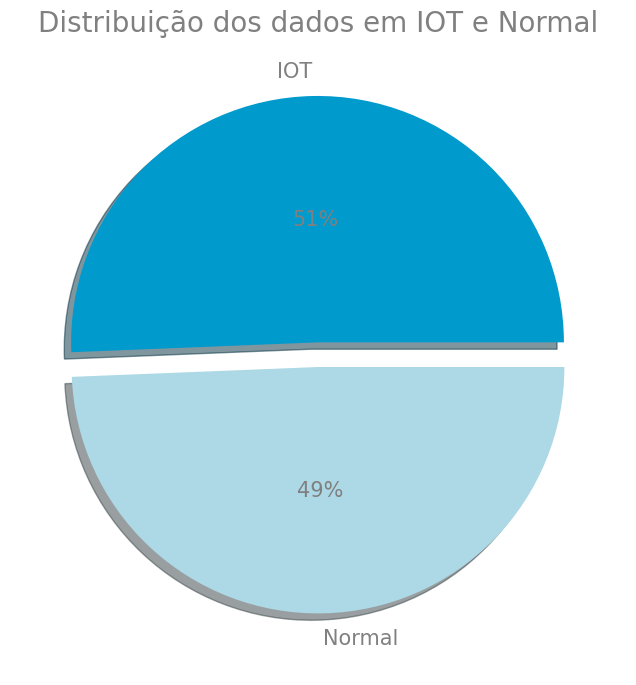

In [10]:
plt.figure(figsize=(10,8))

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = 'gray'
plt.rcParams['axes.labelcolor']= 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['font.size']=15

cores= ['#009ACD', '#ADD8E6']

percentages = [item / dados.shape[0] for item in dados['label'].value_counts()]

labelss = list(dados['label'].value_counts().index.map({0:'Normal',1:'IOT'}))

explode=(0.1,0)

plt.pie(percentages, explode=explode, 
       labels=labelss,
       colors = cores,
       autopct='%1.0f%%',
       shadow=True, startangle=0,   
       pctdistance=0.5,labeldistance=1.1
    )

plt.title("Distribuição dos dados em IOT e Normal", fontsize=20, pad=20)

plt.show()

In [11]:
# Obtendo colunas que temos valores unicos
Unicos = dados.nunique()

Unicos = Unicos[Unicos == 1]

Unicos

vlan_id                      1
bidirectional_cwr_packets    1
bidirectional_ece_packets    1
bidirectional_urg_packets    1
src2dst_cwr_packets          1
src2dst_ece_packets          1
src2dst_urg_packets          1
dst2src_cwr_packets          1
dst2src_ece_packets          1
dst2src_urg_packets          1
dtype: int64

In [12]:
tipos = dados.dtypes

tipos = tipos[tipos == object]

tipos

src_ip                       object
src_mac                      object
src_oui                      object
dst_ip                       object
dst_mac                      object
dst_oui                      object
application_name             object
application_category_name    object
requested_server_name        object
client_fingerprint           object
server_fingerprint           object
user_agent                   object
content_type                 object
dtype: object

## 3-Preparação

Epata em que prepararemos os dados para treinar nosso modelo.

Normalmente eu costumo fazer a filtragem remoção de colunas numéricas no final da etapa 3 para garantir que todos os dados categóricos em que eu não encontrei uma solução viável para transformá-los eu os removo, entretanto, pela natureza dos dados e como eu tenho que ver, as linhas que possuem valores nulos eu vou as remover e não quero que uma coluna que eu não vou usar tenha linhas com dados nulos e atrapalhe meu modelo.

In [13]:
colunas_numericas = dados.select_dtypes(include=['number']).columns

dados = dados[colunas_numericas]

In [14]:
# Obtendo o numero de ocorrencias de valores distintos
cardinalidade = dados.nunique()

# filtrando as colunas que possuiem cardinalidade maior que 1
cardinalidade = cardinalidade[cardinalidade > 1]

dados = dados[list(cardinalidade.index)]

dados

,id,expiration_id,src_port,dst_port,protocol,ip_version,tunnel_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,...,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets,application_is_guessed,application_confidence,label
0,0,0,52754,1900,17,4,0,1493726302410,1493726305380,2970,...,0,0,0,0,0,0,0,0,6,1
1,1,0,5353,5353,17,4,0,1493726302411,1493726305381,2970,...,0,0,0,0,0,0,0,0,6,1
2,2,0,5353,5353,17,6,0,1493726302413,1493726305382,2969,...,0,0,0,0,0,0,0,0,6,1
3,3,0,41081,53,17,4,0,1493726362000,1493726362027,27,...,0,0,0,0,0,0,0,0,6,1
4,4,0,49000,53,17,4,0,1493726344831,1493726344858,27,...,0,0,0,0,0,0,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819587,18695,0,63111,53,17,4,0,11402968,11402997,29,...,0,0,0,0,0,0,0,0,6,0
819588,18696,0,56970,53,17,4,0,11403292,11403311,19,...,0,0,0,0,0,0,0,0,6,0
819589,18697,0,55292,53,17,4,0,11403344,11403361,17,...,0,0,0,0,0,0,0,0,6,0
819590,18698,0,61264,53,17,4,0,11403411,11403431,20,...,0,0,0,0,0,0,0,0,6,0


In [15]:
# removendo 0 ou mais ocorrencias das colunas que possuem application no inicio -> application_name	application_category_name	application_is_guessed	application_confidence

# seleciona as colunas que começão com application para serem removidas
cols_to_drop = dados.filter(regex=r'^application_*')

try:
    # remove todas as colunas contidas na lista
    dados.drop(columns=['src_ip','src_mac', 'dst_ip', 'dst_mac'] + list(cols_to_drop.columns), inplace=True)
except:
    print("já foi removido")

dados.head(10)


já foi removido


,id,expiration_id,src_port,dst_port,protocol,ip_version,tunnel_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,...,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets,application_is_guessed,application_confidence,label
0,0,0,52754,1900,17,4,0,1493726302410,1493726305380,2970,...,0,0,0,0,0,0,0,0,6,1
1,1,0,5353,5353,17,4,0,1493726302411,1493726305381,2970,...,0,0,0,0,0,0,0,0,6,1
2,2,0,5353,5353,17,6,0,1493726302413,1493726305382,2969,...,0,0,0,0,0,0,0,0,6,1
3,3,0,41081,53,17,4,0,1493726362000,1493726362027,27,...,0,0,0,0,0,0,0,0,6,1
4,4,0,49000,53,17,4,0,1493726344831,1493726344858,27,...,0,0,0,0,0,0,0,0,6,1
5,5,0,47903,53,17,4,0,1493726534123,1493726534133,10,...,0,0,0,0,0,0,0,0,6,1
6,6,0,42038,53,17,4,0,1493726536299,1493726536328,29,...,0,0,0,0,0,0,0,0,6,1
7,7,0,45989,53,17,4,0,1493726416750,1493726416821,71,...,0,0,0,0,0,0,0,0,6,1
8,8,0,60516,53,17,4,0,1493726345321,1493726345353,32,...,0,0,0,0,0,0,0,0,6,1
9,9,0,546,547,17,6,0,1493726314176,1493726346238,32062,...,0,0,0,0,0,0,0,0,6,1


In [16]:
# obtendo a quantidade de linhas
limite = len(dados) / 2 

# remove colunas que possuem mais de 50% de valores inválidos
dados.dropna(axis=1, thresh=limite, inplace=True)

# remove todas as linhas que possuem algum valor null or vazio
dados.dropna(axis=0, how='any', inplace=True)

dados.shape

(819592, 64)

In [18]:
# Filtrar as primeiras 100.000 linhas onde label é igual a 1
df_label_1 = dados[dados['label'] == 1].head(100000)

# Filtrar as primeiras 100.000 linhas onde label é igual a 0
df_label_0 = dados[dados['label'] == 0].head(100000)

# Concatenar os DataFrames resultantes
dados = pd.concat([df_label_1, df_label_0])

dados.reset_index()
# Agora o result_df contém as 100.000 primeiras linhas com label 1 e as 100.000 primeiras linhas com label 0
dados

,id,expiration_id,src_port,dst_port,protocol,ip_version,tunnel_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,...,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets,application_is_guessed,application_confidence,label
0,0,0,52754,1900,17,4,0,1493726302410,1493726305380,2970,...,0,0,0,0,0,0,0,0,6,1
1,1,0,5353,5353,17,4,0,1493726302411,1493726305381,2970,...,0,0,0,0,0,0,0,0,6,1
2,2,0,5353,5353,17,6,0,1493726302413,1493726305382,2969,...,0,0,0,0,0,0,0,0,6,1
3,3,0,41081,53,17,4,0,1493726362000,1493726362027,27,...,0,0,0,0,0,0,0,0,6,1
4,4,0,49000,53,17,4,0,1493726344831,1493726344858,27,...,0,0,0,0,0,0,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515016,64996,0,47450,53,17,4,0,1493731888452,1493731888676,224,...,0,0,0,0,0,0,0,0,6,0
515017,64997,0,46868,80,6,4,0,1493731888499,1493731889862,1363,...,0,1,0,5,3,0,1,0,6,0
515018,64998,0,60602,80,6,4,0,1493731888500,1493731889579,1079,...,0,1,1,5,2,0,1,0,6,0
515019,64999,0,51546,80,6,4,0,1493731888573,1493731892405,3832,...,0,1,1,2,0,0,1,1,1,0


In [19]:
dados['label'].value_counts()

1    100000
0    100000
Name: label, dtype: int64

## 4- Modelagem

### Modelos

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
import random

teste_size = random.randrange(10, 40) / 100

data_x = dados.drop(columns=['label','id'])

data_y = dados['label']

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=teste_size, random_state=42)

models = DataFrame() # onde serão quardadas as saidas

* Selecionando as melhores variaveis reditores com o algoritmo [Boruta](https://medium.com/data-hackers/como-selecionar-melhores-vari%C3%A1veis-para-o-seu-modelo-com-boruta-ef7cbfb3fc35).

In [117]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

feat_selector.fit(train_x.values, train_y.values)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	62
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	62
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	62
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	62
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	62
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	62
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	62
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	56
Tentative: 	6
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	56
Tentative: 	6
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	56
Tentative: 	4
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	56
Tentative: 	4
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	59
Tentative: 	1
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	59
Tentative: 	1
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	59
Tentative: 	1
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	59
Tentative: 	1
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	59
Tentative: 	1
Rejected: 	2
I

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=219, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F4FDAB2BB40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F4FDAB2BB40, verbose=2)

In [119]:
# filtrado as features relevantes selecionadas pelo boruta
train_x = train_x.iloc[:, feat_selector.support_.tolist()]

test_x = test_x.iloc[:, feat_selector.support_.tolist()]

In [120]:
from sklearn.ensemble import RandomForestClassifier

RFClf = RandomForestClassifier()

RFClf.fit(train_x, train_y)

rfclf_y = RFClf.predict(test_x)

models['RFClf'] = rfclf_y

In [121]:
accuracy = accuracy_score(test_y, rfclf_y)

print(accuracy)

0.5558557692307692


In [122]:
confusion_matrix(test_y, rfclf_y)

array([[27665, 24194],
       [21997, 30144]])

In [123]:
from sklearn.neighbors import KNeighborsClassifier

Knn = KNeighborsClassifier(n_neighbors=2)

Knn.fit(train_x, train_y)

knn_y = Knn.predict(test_x)

models['KNN'] = knn_y

In [124]:
accuracy = accuracy_score(test_y, knn_y)

print(accuracy)

0.574


In [125]:
import xgboost

XGB = xgboost.XGBClassifier()

XGB.fit(train_x, train_y)

xgb_y = XGB.predict(test_x)

models['XGB'] = xgb_y

In [126]:
accuracy = accuracy_score(test_y, xgb_y)

print(accuracy)

0.7231346153846154


In [127]:
confusion_matrix(test_y, xgb_y)

array([[30587, 21272],
       [ 7522, 44619]])

* HistGradientBoostingClassifier para substituir o lighgbm

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier



In [128]:
import lightgbm as lightGBM

GBM_train = lightGBM.Dataset(train_x, train_y)

params = {
    'objective': 'regression',  # Problema de regressão
    'metric': 'rmse',          # Métrica de avaliação: erro médio quadrático
    'boosting_type': 'gbdt',   # Tipo de boosting: Gradient Boosting Decision Tree
    'num_leaves': 31,          # Número máximo de folhas em uma árvore
    'learning_rate': 0.05,     # Taxa de aprendizado
    'feature_fraction': 0.9,   # Fração de features a serem considerados em cada árvore
}

# Treinando o modelo
model = lightGBM.train(params, GBM_train, num_boost_round=100)

# Fazendo previsões no conjunto de teste
gbm_y = model.predict(test_x)

# Avaliando o modelo
rmse = np.sqrt(mean_squared_error(test_y, gbm_y))
print(f'RMSE: {rmse}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11832
[LightGBM] [Info] Number of data points in the train set: 296000, number of used features: 59
[LightGBM] [Info] Start training from score 0.499524
RMSE: 0.39751156639186785


Referencia do modelo [catboost](https://catboost.ai/docs/)

In [129]:
import catboost

CatBClf = catboost.CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss')

CatBClf.fit(train_x, train_y, verbose=False)

cb_y = CatBClf.predict(test_x)

models['CB'] = cb_y

In [130]:
accuracy = accuracy_score(test_y, cb_y)

accuracy

0.727326923076923

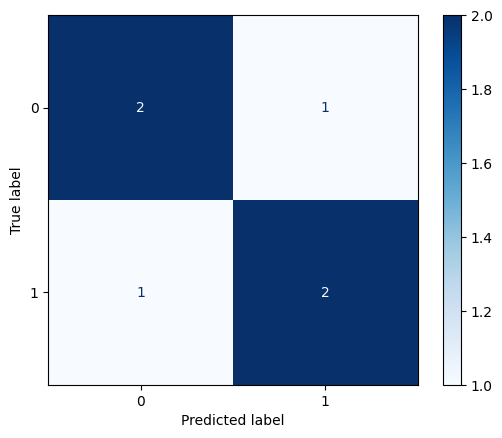

In [4]:
# Importar as bibliotecas necessárias
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Criar uma matriz de confusão fictícia
y_true = [0, 1, 0, 1, 0, 1]
y_pred = [0, 0, 0, 1, 1, 1]
cm = confusion_matrix(y_true, y_pred)

# Criar um objeto ConfusionMatrixDisplay com a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plotar a imagem da matriz de confusão
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [ ]:
from sklearn.svm import SVC

SVClf = SVC()

SVClf.fit(train_x, train_y)

svc_y = SVClf.predict(test_x)

models['SVC'] = svc_y

In [132]:
# ref -> https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
from sklearn.naive_bayes import GaussianNB

NBayes = GaussianNB()

NBayes.fit(train_x, train_y)

nb_y = NBayes.predict(test_x)

models['NBayes'] = nb_y

In [133]:
def calculate_leaderboard (models:DataFrame) -> DataFrame:

    leaderboard = DataFrame(columns= list(models.columns))

    for col in list(leaderboard.columns):

        leaderboard.at['accuracy', col] = round(accuracy_score(test_y, np.array(models[col])) * 100, 4)

        matrix = confusion_matrix(test_y, np.array(models[col]))
        
        leaderboard.at['precision', col] = round(precision_score(test_y, np.array(models[col])) * 100, 4)

        leaderboard.at['recall', col] = round(recall_score(test_y, np.array(models[col])) * 100, 4)

        leaderboard.at['f1_score', col] = round(f1_score(test_y, np.array(models[col])) * 100, 4)
    
    leaderboard['mean all'] = [round(i, 4) for i in leaderboard.mean(axis=1).values]

    return leaderboard, 

myleaderboard = calculate_leaderboard(models)

myleaderboard

,RFClf,KNN,XGB,CB,NBayes,mean all
accuracy,55.5856,57.4,72.3135,72.7327,65.9394,64.7942
FP,24194,12433,21272,23880,32001,22756.0000
FN,21997,31871,7522,4478,3422,13858.0000
precision,55.475,61.9821,67.7164,66.6215,60.3556,62.4301
recall,57.8125,38.8754,85.5737,91.4117,93.437,73.4221
f1_score,56.6196,47.7818,75.6049,77.0722,73.3383,66.0834


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

modelos = [
    (
        'RFClf',
        RandomForestClassifier(),
        {
            'n_estimators':[int(i) for i in range(50, 1000, 50)],
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_depth':[int(i) for i in range(14)],
            'min_samples_leaf':[i for i in range(14)],
            'max_samples':[(i / 14) for i in range(14)],
            'max_features':['sqrt', 'log2'],
            'bootstrap':[True, False],
            'random_state':[0,42],
            'n_jobs':[-1]
        }
    )
]

for name, clf, paramss in modelos:
    
    print(name)

    algritm = RandomizedSearchCV(clf, paramss, cv = 5)
 
    algritm.fit(training_x, training_y)

    y_pred = algritm.predict(test_x)

    print(f'acuracia: {accuracy_score(teste_y, y_pred)} f1 {f1_score(teste_y, y_pred)}')

Task 7-
* O trafico que estava sendo usado no trabalho anterior estava muito poluido com trafego de dispositivos que não faziam sentido para nosso trabalho então Normal -> [7,10,13] e IOT 


Task 6 - Inicio da faze de treinamento
1. Relatório das colunas excluidas.
2. Desafio do titanic.
3. Criar um modelosup com os dados obtidos até o momento.

Task 5
Fonte dos dados: [iotanalytics](https://iotanalytics.unsw.edu.au/) e [stratosphereips](https://www.stratosphereips.org/datasets-normal)

1. Criar script que receba um `.pcap` e e gere um `.csv` limpo (excluir as colunas IP O/D,mac O/D, APPlication* e excluir colunas vazias)
2. Escolher um numero de pcaps do IOT analitcs e tratar (~ 400k de fluxos)
3. Gerar fluxos já tratados
4. Rotular os fluxos: criar a coluna "target" (0 -> trafego normal, 1 -> IOT)
5. Unir os arquivos cvs